In [176]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import os
import matplotlib.pyplot as plt
%matplotlib inline

In [177]:
np.random.seed(42)

# Portfolio Planner

In this activity, you will use the iexfinance api to grab historical data for a 60/40 portfolio using `SPY` to represent the stock portion and `AGG` to represent the bonds.

In [178]:
import alpaca_trade_api as tradeapi

# Set Alpaca API key and secret
alpaca_api_key = os.getenv("ALPACA_API_KEY")
alpaca_secret_key = os.getenv("ALPACA_SECRET_KEY")
# Initialize the API
api = tradeapi.REST(alpaca_api_key, alpaca_secret_key, api_version='v2')

# Data Collection

In this step, you will need to use the IEX api to fetch closing prices for the `SPY` and `AGG` tickers. Save the results as a pandas DataFrame

In [179]:
tickers = ["SPY", "AGG"]
timeframe = "1D"
end_date = datetime.now()
start_date = end_date + timedelta(252)
combo_df = api.get_barset(
    tickers,
    timeframe,
    limit=None,
    start=start_date,
    end=end_date,
    after=None,
    until=None,
).df

combo_df.head()

AGG                                         \
                             open      high       low     close   volume   
2019-11-21 00:00:00-05:00  112.80  112.8859  112.7200  112.8131  3971410   
2019-11-22 00:00:00-05:00  112.89  112.9000  112.7605  112.8500  2233649   
2019-11-25 00:00:00-05:00  112.91  113.0100  112.8900  112.9800  2848536   
2019-11-26 00:00:00-05:00  113.11  113.1590  113.0800  113.1200  2104446   
2019-11-27 00:00:00-05:00  113.03  113.0700  112.9600  112.9950  1844546   

                              SPY                                    
                             open    high     low   close    volume  
2019-11-21 00:00:00-05:00  310.89  311.01  309.39  310.29  42497606  
2019-11-22 00:00:00-05:00  310.90  311.24  309.85  311.00  32532889  
2019-11-25 00:00:00-05:00  311.98  313.37  311.98  313.35  37229034  
2019-11-26 00:00:00-05:00  313.41  314.28  313.06  314.02  30435576  
2019-11-27 00:00:00-05:00  314.61  315.47  314.37  315.46  34799247

In [180]:
combo_df.drop(columns=['open', 'high', 'low', 'volume'], level=1, inplace=True)
combo_df.head()

,AGG,SPY
,close,close
2019-11-21 00:00:00-05:00,112.8131,310.29
2019-11-22 00:00:00-05:00,112.8500,311.00
2019-11-25 00:00:00-05:00,112.9800,313.35
2019-11-26 00:00:00-05:00,113.1200,314.02
2019-11-27 00:00:00-05:00,112.9950,315.46


# Monte Carlo Simulation

In this step, you will run Monte Carlo Simulations for your portfolio to model portfolio performance at different retirement ages. 

Complete the following steps:
1. Calculate the daily returns for the SPY and AGG closing prices.
2. Calculate volatility for both the SPY and AGG closing prices.
3. Find the last day's closing price for both stocks and save those as variables.
4. Run a Monte Carlo Simulation of at least 500 iterations and generate at least 30 years of closing prices

### HINTS:
There are 252 trading days per year, so the number of records to generate for each Monte Carlo run will be 252 days * 30 years

In [181]:
# Calculate the daily roi for the stocks
daily_returns = combo_df.pct_change()
daily_returns.head()

,AGG,SPY
,close,close
2019-11-21 00:00:00-05:00,NaN,NaN
2019-11-22 00:00:00-05:00,0.000327,0.002288
2019-11-25 00:00:00-05:00,0.001152,0.007556
2019-11-26 00:00:00-05:00,0.001239,0.002138
2019-11-27 00:00:00-05:00,-0.001105,0.004586


In [182]:
avg_daily_return_agg = daily_returns.mean()['AGG']['close']
avg_daily_return_spy = daily_returns.mean()['SPY']['close']
print(f" AGG Average Daily Return: {avg_daily_return_agg}")
print(f" SPY Average Daily Return: {avg_daily_return_spy}")

 AGG Average Daily Return: 0.00043700403210573285
 SPY Average Daily Return: -0.0006103598985130695


In [183]:
# Calculate volatility
std_dev_daily_return_agg = daily_returns.std()['AGG']['close']
std_dev_daily_return_spy = daily_returns.std()['SPY']['close']
print(f" AGG Standard Deviation: {std_dev_daily_return_agg}")
print(f" SPY Standard Deviation: {std_dev_daily_return_spy}")

 AGG Standard Deviation: 0.008493394040698092
 SPY Standard Deviation: 0.030190440652702925


In [184]:
# Save the last day's closing price
spy_last = combo_df["SPY"]["close"][-1]
agg_last = combo_df["AGG"]["close"][-1]
print(spy_last)
print(agg_last)

279.21
117.38


In [185]:
# Setup the Monte Carlo Parameters
number_simulations = 500
number_records = 252*30
monte_carlo = pd.DataFrame()
portfolio_cumulative_returns = pd.DataFrame()

In [186]:
# Run the Monte Carlo Simulation

for n in range(number_simulations):

    simulated_agg_prices = [agg_last]
    simulated_spy_prices = [spy_last]
    
    for i in range(number_records):
        
        simulated_agg_price = simulated_agg_prices[-1] * (1 + np.random.normal(avg_daily_return_agg, std_dev_daily_return_agg))
        simulated_spy_price = simulated_spy_prices[-1] * (1 + np.random.normal(avg_daily_return_spy, std_dev_daily_return_spy))
        
        simulated_agg_prices.append(simulated_agg_price)
        simulated_spy_prices.append(simulated_spy_price)
    
#     monte_carlo["AGG Prices"] = pd.Series(simulated_agg_prices)
#     monte_carlo["SPY Prices"] = pd.Series(simulated_spy_prices)

    portfolio = pd.DataFrame({
        "SPY Simulated Prices": simulated_spy_prices,
        "AGG Simulated Prices": simulated_agg_prices
    })
    
    simulated_daily_returns = portfolio.pct_change()
    
    weights = [0.40, 0.60]
    
    portfolio_daily_returns = simulated_daily_returns.dot(weights)
    
    portfolio_cumulative_returns[n] = (1 + portfolio_daily_returns.fillna(0)).cumprod()
    
portfolio_cumulative_returns.head()


,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,1.000880,0.996539,0.990729,1.010971,1.030493,0.988677,0.997150,1.028222,1.001219,0.986026,...,1.004365,0.977280,1.006979,1.004485,0.987780,1.007662,0.999535,1.010736,0.995403,0.983361
2,1.022610,1.007149,0.999889,0.986773,1.024923,0.980445,0.984126,1.003955,0.997053,0.983596,...,1.012729,0.984226,1.010624,1.012112,0.989070,0.975434,0.999915,1.005510,0.988304,0.993675
3,1.018517,1.003939,1.000531,0.984786,1.017844,0.964406,0.994295,0.983683,0.994870,1.006750,...,1.013170,0.969125,1.013509,1.021828,0.972681,0.979130,1.013746,0.991657,0.994531,1.001786
4,1.036171,1.009499,1.007752,0.997118,1.031398,0.967273,1.003746,0.965708,1.002279,1.010019,...,1.005932,0.974899,1.012013,1.007813,0.978267,0.973607,1.001710,0.997637,0.991211,1.003848


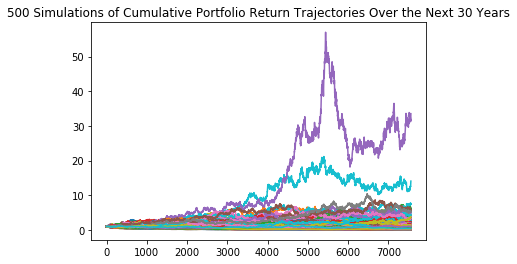

In [203]:
# Visualize the Simulation
plot_title = f"{n+1} Simulations of Cumulative Portfolio Return Trajectories Over the Next 30 Years"
portfolio_cumulative_returns.plot(legend=None, title=plot_title)

In [204]:
# Select the last row for the cumulative returns (cumulative returns at 30 years)
ending_cumulative_returns = portfolio_cumulative_returns.iloc[-1, :]
ending_cumulative_returns.head()

0    0.639481
1    0.427451
2    0.567917
3    0.314025
4    0.537667
Name: 7560, dtype: float64

(-0.0138, 3.068]    0.940
(3.068, 6.116]      0.050
(6.116, 9.163]      0.006
(30.495, 33.543]    0.002
(12.211, 15.258]    0.002
(27.448, 30.495]    0.000
(24.4, 27.448]      0.000
(21.353, 24.4]      0.000
(18.305, 21.353]    0.000
(15.258, 18.305]    0.000
(9.163, 12.211]     0.000
Name: 7560, dtype: float64


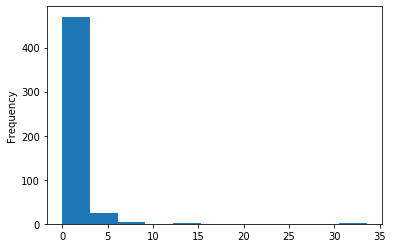

In [205]:
# Display the 90% confidence interval for the ending returns in 30 Years
ending_cumulative_returns.plot(kind='hist', bins=11)
count = ending_cumulative_returns.value_counts(bins=11) / len(ending_cumulative_returns)
confidence_interval = ending_cumulative_returns.quantile(q=[0.05, 0.95])
print(count)

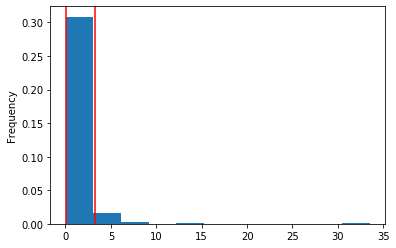

In [206]:
# Visualize the distribution of the ending returns
plt.figure();
ending_cumulative_returns.plot(kind='hist', density=True, bins=11)
plt.axvline(confidence_interval.iloc[0], color='r')
plt.axvline(confidence_interval.iloc[1], color='r')

---

# Retirement Analysis

In this section, you will use the monte carlo model to answer the following retirement planning questions:

1. What are the expected cumulative returns at 30 years for the 10th, 50th, and 90th percentiles?
2. Given an initial investment of `$20,000`, what is the expected portfolio return in dollars at the 10th, 50th, and 90th percentiles?
3. Given the current projected annual income from the Plaid analysis, will a 4% withdraw rate from the retirement portfolio meet or exceed that value at the 10th percentile?
4. How would a 50% increase in the initial investment amount affect the 4% retirement withdrawal?

### What are the expected cumulative returns at 30 years for the 10th, 50th, and 90th percentiles?

In [191]:
# ending_returns = monte_carlo.iloc[-1, :]

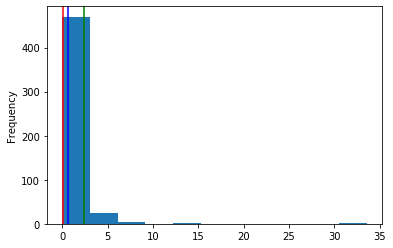

In [198]:
# 30 years 90th and 10th percentile
ending_cumulative_returns.plot(kind='hist', bins=11)
ending_cumulative_returns.value_counts(bins=11) / len(ending_cumulative_returns)
confidence_interval1 = ending_cumulative_returns.quantile([.1, .5, .9])
plt.axvline(confidence_interval1.iloc[0], color='r')
plt.axvline(confidence_interval1.iloc[1], color='b')
plt.axvline(confidence_interval1.iloc[2], color='g')

### Given an initial investment of `$20,000`, what is the expected portfolio return in dollars at the 10th, 50th, and 90th percentiles?

In [199]:
initial_investment = 20000

# Calculate investment profit/loss of lower and upper bound cumulative portfolio returns
investment_pnl_lower_bound = (initial_investment * (1 + confidence_interval1.iloc[0]))
investment_pnl_upper_bound = (initial_investment * (1 + confidence_interval1.iloc[1]))
investment_pnl_far_upper_bound = (initial_investment * (1 + confidence_interval1.iloc[2]))                                                 

# Print the results
print(f"There is a 90% chance that an initial investment of $20,000 in the portfolio"
      f" over the next 30 years will end within in the range of"
      f" ${investment_pnl_lower_bound} and ${investment_pnl_upper_bound}")

There is a 90% chance that an initial investment of $20,000 in the portfolio over the next 30 years will end within in the range of $22791.006203709912 and $32350.907138652376


### Given the current projected annual income from the Plaid analysis, will a 4% withdraw rate from the retirement portfolio meet or exceed that value at the 10th percentile?

Note: This is effectively saying that 90% of the expected returns will be greater than the return at the 10th percentile, so this can help measure the uncertainty about having enough funds at retirement

In [200]:
answer1 = .04 * (initial_investment * confidence_interval1).iloc[0]
answer1

111.6402481483965

### How would a 50% increase in the initial investment amount affect the 4% retirement withdrawal?

In [201]:
answer2 = .04 * (initial_investment * confidence_interval1).iloc[1]
answer2

494.0362855460952

In [202]:
answer3 = .04 * (initial_investment * confidence_interval1).iloc[2]
answer3

1903.0097698432685

### Optional Challenge

In this section, you will calculate and plot the cumulative returns for the median and 90% confidence intervals. This plot shows the expected cumulative returns for any given day between the first day and the last day of investment. 